In [1]:
import os
import joblib
import json

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score, multilabel_confusion_matrix, \
    classification_report, accuracy_score

import numpy as np
import matplotlib.pyplot as plt

import torch

In [ ]:
# TODO: instead of averaging models of all types, we should only average models
# trained with the same set of hyperparameters

# TODO: since training is a random process, we can also train several models
# using the same hyperparameters and partition of the dataset. Then, when
# averaging, we should average over models with the same hyperparameters but
# different dataset partition

# Create datasets

In [2]:
cwd = os.getcwd()

datasets = ['Chowell_train', 'Chowell_test', 'MSK1', 'MSK2', 'Shim_NSCLC',
            'Kato_panCancer', 'Vanguri_NSCLC', 'Ravi_NSCLC', 'Pradat_panCancer']
datasets_ids = list(range(1, len(datasets) + 1))

In [ ]:
# Create whole models dataset
model_name = 'llr6' # 'llr6' or 'nn2'
scaler_type = 'standard' # 'standard' or 'minimax'

all_labels = []
all_params = []
all_scores = []
all_means = []
all_scales = []

datasets_dir = os.path.join(cwd, 'datasets', model_name, scaler_type)
os.makedirs(datasets_dir, exist_ok=True)

models_dir = os.path.join(cwd, 'models', model_name, scaler_type)
for comb in os.listdir(models_dir):
    aux_labels = [int(n) - 1 for n in comb.split('_')]
    one_hot_label = torch.zeros(len(datasets))
    one_hot_label[aux_labels] = 1
    
    comb_dir = os.path.join(models_dir, comb)
    for file in os.listdir(comb_dir):
        if file.split('_')[-1] == 'params.pkl':
            params_dir = os.path.join(comb_dir, file)
            params = joblib.load(params_dir)
            
            if model_name == 'nn2':
                coefs = [torch.from_numpy(c).flatten()
                         for c in params['coefs_']]
                coefs = torch.cat(coefs)
                intercepts = [torch.from_numpy(c).flatten()
                              for c in params['intercepts_']]
                intercepts = torch.cat(intercepts)
            else: #if model_name == 'llr6':
                coefs = torch.from_numpy(params['coef_']).flatten()
                intercepts = torch.from_numpy(params['intercept_']).flatten()
            
            params = torch.cat([coefs, intercepts])
            
            all_labels.append(one_hot_label.clone())
            all_params.append(params.clone())
        
        elif file.split('_')[-1] == 'scores.json':
            scores_dir = os.path.join(comb_dir, file)
            with open(scores_dir, 'r') as f:
                scores_dict = json.load(f)
            
            aux_labels = [int(n) - 1 for n in comb.split('_')]
            scores_vector = torch.zeros(len(datasets) + 1)
            for dat_id in datasets_ids:
                scores_vector[dat_id - 1] = scores_dict[str(dat_id)]
            scores_vector[-1] = scores_dict['all']
            
            all_scores.append(scores_vector)
        
        elif '_'.join(file.split('_')[-2:]) == 'scaler_info.pkl':
            scaler_info_dir = os.path.join(comb_dir, file)
            scaler_info_dict = joblib.load(scaler_info_dir)
            
            aux_mean = torch.from_numpy(scaler_info_dict['mean'])
            aux_scale = torch.from_numpy(scaler_info_dict['scale'])
            
            all_means.append(aux_mean)
            all_scales.append(aux_scale)

all_labels = torch.stack(all_labels, dim=0).int()
all_params = torch.stack(all_params, dim=0)
all_scores = torch.stack(all_scores, dim=0)
all_means = torch.stack(all_means, dim=0)
all_scales = torch.stack(all_scales, dim=0)

# torch.save((all_labels, all_params, all_scores, all_means, all_scales),
#            os.path.join(datasets_dir, 'params_multilabel.pt'))

# LLR6

## Load and filter datasets

In [3]:
model_name = 'llr6' # 'llr6' or 'nn2'
scaler_type = 'standard' # 'standard' or 'minimax'
dataset_dir = os.path.join(cwd, 'datasets', model_name, scaler_type,
                           'params_multilabel.pt')

all_labels, all_params, all_scores, all_means, all_scales = \
    torch.load(dataset_dir, weights_only=True)

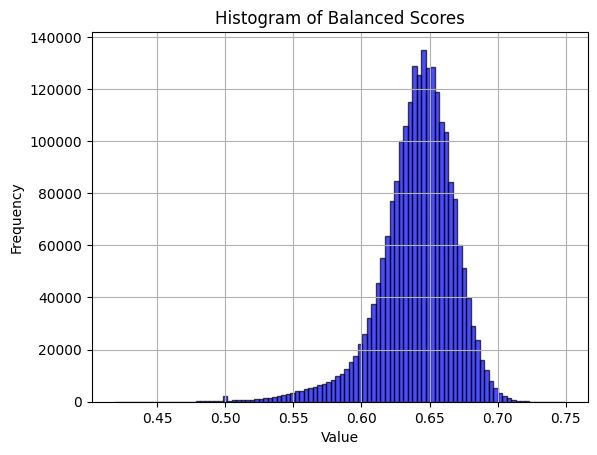

In [4]:
# Plot histogram scores
plt.hist(all_scores[:, -1].numpy(), bins=100, alpha=0.7,
         color='blue', edgecolor='black')
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Balanced Scores")
plt.grid(True)

# Show plot
plt.show()

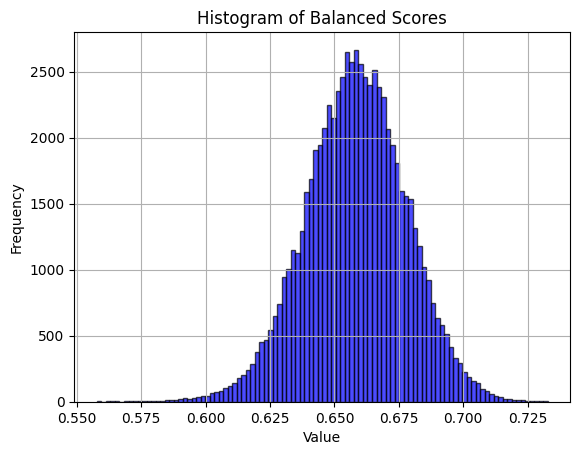

In [5]:
# Plot histogram scores
idx = (all_scores >= 0.55).all(dim=1)
# idx = (all_scores[:, -1] >= 0.55)
filtered_scores = all_scores[idx]
plt.hist(filtered_scores[:, -1].numpy(), bins=100, alpha=0.7,
         color='blue', edgecolor='black')
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Balanced Scores")
plt.grid(True)

# Show plot
plt.show()

In [6]:
lower_bound = 0.55

idx = (all_scores >= lower_bound).all(dim=1)
# idx = (all_scores[:, -1] >= lower_bound)

all_labels = all_labels[idx]
all_params = all_params[idx]
all_scores = all_scores[idx]
all_means = all_means[idx]
all_scales = all_scales[idx]

### Average models

In [92]:
avg_len = 10

datasets_dir = os.path.join(cwd, 'datasets', model_name, scaler_type)
os.makedirs(datasets_dir, exist_ok=True)

all_labels_avg = []
all_params_avg = []
all_means_avg = []
all_scales_avg = []

models_dir = os.path.join(cwd, 'models', model_name, scaler_type)
for comb in os.listdir(models_dir):
    aux_labels = [int(n) - 1 for n in comb.split('_')]
    one_hot_label = torch.zeros(len(datasets))
    one_hot_label[aux_labels] = 1
    
    comb_ids = (all_labels == one_hot_label.unsqueeze(0)).all(dim=1)
    
    for i in range(comb_ids.sum() // avg_len):
        all_labels_avg.append(one_hot_label)
        
        aux_params = all_params[comb_ids][(i * avg_len):((i + 1) * avg_len)]
        aux_params = aux_params.mean(dim=0)
        all_params_avg.append(aux_params)
        # NOTE: we use a different scaler?
        # Should we also correct with the scaler info?
        
        aux_means = all_means[comb_ids][(i * avg_len):((i + 1) * avg_len)]
        aux_means = aux_means.mean(dim=0)
        all_means_avg.append(aux_means)
        
        aux_scales = all_scales[comb_ids][(i * avg_len):((i + 1) * avg_len)]
        aux_scales = aux_scales.mean(dim=0)
        all_scales_avg.append(aux_scales)

all_labels_avg = torch.stack(all_labels_avg, dim=0).int()
all_params_avg = torch.stack(all_params_avg, dim=0)
all_means_avg = torch.stack(all_means_avg, dim=0)
all_scales_avg = torch.stack(all_scales_avg, dim=0)

# torch.save((all_labels_avg, all_params_avg, all_means_avg, all_scales_avg),
#            os.path.join(datasets_dir, 'params_multilabel_avg.pt'))

In [93]:
model_name = 'llr6' # 'llr6' or 'nn2'
scaler_type = 'standard' # 'standard' or 'minimax'
dataset_dir = os.path.join(cwd, 'datasets', model_name, scaler_type,
                           'params_multilabel_avg.pt')

all_labels_avg, all_params_avg, all_means_avg, all_scales_avg = \
    torch.load(dataset_dir, weights_only=True)

In [94]:
all_params.shape, all_params_avg.shape

(torch.Size([71084, 22]), torch.Size([6877, 22]))

### Rescale coeffs

In [95]:
# Split coefficients and intercept
weights = all_params_avg[:, :-1]      # (n, f)
intercept = all_params_avg[:, -1]     # (n,)

# Rescale weights
new_weights = weights / all_scales_avg  # element-wise division

# Adjust intercept
intercept_shift = torch.sum(weights * all_means_avg / all_scales_avg, dim=1)  # (n,)
new_intercept = intercept - intercept_shift  # (n,)

# Concatenate back
new_coef_tensor = torch.cat([new_weights, new_intercept.unsqueeze(1)], dim=1)  # (n, f+1)

all_params_avg = new_coef_tensor

## Black-box attack

In [15]:
# Black-box attack
X, y = all_scores, all_labels

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

# Define and train the MLP model
mlp_bb = MLPClassifier(hidden_layer_sizes=(256, 128, 64, 32,),
                       activation="relu",
                       solver="adam",
                       max_iter=1000)
mlp_bb.fit(X_train, y_train)

# Save model
attack_model_dir = os.path.join(cwd, 'attack_models', model_name)
os.makedirs(attack_model_dir, exist_ok=True)

joblib.dump(mlp_bb, os.path.join(attack_model_dir,
                                 'mlp_attacker_multilabel_bb.pkl'))

['/home/jose/VSCodeProjects/LORIS/attacks/attack_models/llr6/mlp_attacker_multilabel_bb.pkl']

In [16]:
attack_model_dir = os.path.join(cwd, 'attack_models', model_name)
mlp_bb = joblib.load(os.path.join(attack_model_dir,
                                  'mlp_attacker_multilabel_bb.pkl'))

In [17]:
# Predict probabilities and binary labels
y_pred = mlp_bb.predict(X_test)

# Evaluate using F1-score
print("F1-score:", f1_score(y_test, y_pred, average="micro"))
print()

# Compute the confusion matrix for each label separately
conf_matrices = multilabel_confusion_matrix(y_test, y_pred)

# Display confusion matrices per class
for i, cm in enumerate(conf_matrices):
    cm_sum = cm.astype(np.float64).sum(axis=1, keepdims=True)  # Sum per row
    cm_normalized = cm / (cm_sum + 1e-9)  # Avoid division by zero
    print(f"Confusion Matrix for Class {i} - {datasets[i]}:\n{cm_normalized}\n")
print()

# Generate a detailed classification report
print(classification_report(y_test, y_pred, zero_division=0))

F1-score: 0.5896249506514015

Confusion Matrix for Class 0 - Chowell_train:
[[0.16810831 0.83189169]
 [0.0327003  0.9672997 ]]

Confusion Matrix for Class 1 - Chowell_test:
[[0.20594099 0.79405901]
 [0.0685795  0.9314205 ]]

Confusion Matrix for Class 2 - MSK1:
[[0.62919574 0.37080426]
 [0.49214502 0.50785498]]

Confusion Matrix for Class 3 - MSK2:
[[0.91269626 0.08730374]
 [0.73788256 0.26211744]]

Confusion Matrix for Class 4 - Shim_NSCLC:
[[0.47430887 0.52569113]
 [0.39942529 0.60057471]]

Confusion Matrix for Class 5 - Kato_panCancer:
[[0.98974294 0.01025706]
 [0.98655063 0.01344937]]

Confusion Matrix for Class 6 - Vanguri_NSCLC:
[[0.18924097 0.81075903]
 [0.10145318 0.89854682]]

Confusion Matrix for Class 7 - Ravi_NSCLC:
[[0.78042405 0.21957595]
 [0.58682308 0.41317692]]

Confusion Matrix for Class 8 - Pradat_panCancer:
[[0.92376459 0.07623541]
 [0.8658121  0.1341879 ]]


              precision    recall  f1-score   support

           0       0.66      0.97      0.79      8899

## White-box attack

In [9]:
# White-box attack
X, y = all_params, all_labels

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

# Define and train the MLP model
mlp_wb = MLPClassifier(hidden_layer_sizes=(256, 128, 64, 32),
                       activation="relu",
                       solver="adam",
                       max_iter=1000)
mlp_wb.fit(X_train, y_train)

# Save model
attack_model_dir = os.path.join(cwd, 'attack_models', model_name)
os.makedirs(attack_model_dir, exist_ok=True)

# joblib.dump(mlp_wb, os.path.join(attack_model_dir,
#                                  'mlp_attacker_multilabel_wb.pkl'))
# joblib.dump(mlp_wb, os.path.join(attack_model_dir,
#                                  'mlp_attacker_multilabel_wb_bigmodel.pkl'))

['/home/jose/VSCodeProjects/LORIS/attacks/attack_models/llr6/mlp_attacker_multilabel_wb.pkl']

In [10]:
attack_model_dir = os.path.join(cwd, 'attack_models', model_name)
mlp_wb = joblib.load(os.path.join(attack_model_dir,
                                  'mlp_attacker_multilabel_wb.pkl'))
# mlp_wb = joblib.load(os.path.join(attack_model_dir,
#                                   'mlp_attacker_multilabel_wb_bigmodel.pkl'))

In [11]:
# Predict probabilities and binary labels
y_pred = mlp_wb.predict(X_test)

# Evaluate using F1-score
print("F1-score:", f1_score(y_test, y_pred, average="micro"))
print()

# Compute the confusion matrix for each label separately
conf_matrices = multilabel_confusion_matrix(y_test, y_pred)

# Display confusion matrices per class
for i, cm in enumerate(conf_matrices):
    cm_sum = cm.astype(np.float64).sum(axis=1, keepdims=True)  # Sum per row
    cm_normalized = cm / (cm_sum + 1e-9)  # Avoid division by zero
    print(f"Confusion Matrix for Class {i} - {datasets[i]}:\n{cm_normalized}\n")
print()

# Generate a detailed classification report
print(classification_report(y_test, y_pred, zero_division=0))

F1-score: 0.8282928770393951

Confusion Matrix for Class 0 - Chowell_train:
[[0.95802469 0.04197531]
 [0.03754266 0.96245734]]

Confusion Matrix for Class 1 - Chowell_test:
[[0.8658147  0.1341853 ]
 [0.07817109 0.92182891]]

Confusion Matrix for Class 2 - MSK1:
[[0.84988453 0.15011547]
 [0.08064516 0.91935484]]

Confusion Matrix for Class 3 - MSK2:
[[0.74545455 0.25454545]
 [0.29637097 0.70362903]]

Confusion Matrix for Class 4 - Shim_NSCLC:
[[0.81598063 0.18401937]
 [0.15051903 0.84948097]]

Confusion Matrix for Class 5 - Kato_panCancer:
[[0.65148515 0.34851485]
 [0.52263374 0.47736626]]

Confusion Matrix for Class 6 - Vanguri_NSCLC:
[[0.528      0.472     ]
 [0.18533605 0.81466395]]

Confusion Matrix for Class 7 - Ravi_NSCLC:
[[0.8807947  0.1192053 ]
 [0.05762082 0.94237918]]

Confusion Matrix for Class 8 - Pradat_panCancer:
[[0.68080357 0.31919643]
 [0.11233886 0.88766114]]


              precision    recall  f1-score   support

           0       0.97      0.96      0.97       586

### Evaluate LORIS

In [62]:
def classify_by_dataset(model, params):
    probs = model.predict_proba(params)[0, :]
    
    for i in range(len(datasets)):
        print(f'{datasets[i]:>16}: {probs[i]:.4f}')

In [63]:
# ['TMB', 'Systemic_therapy_history', 'Albumin', 'NLR', 'Age',
#  'CancerType1', 'CancerType2', 'CancerType3', 'CancerType4',
#  'CancerType5', 'CancerType6', 'CancerType7', 'CancerType8',
#  'CancerType9', 'CancerType10', 'CancerType11', 'CancerType12',
#  'CancerType13', 'CancerType14', 'CancerType15', 'CancerType16']

# S = 0.0371 * min(TMB, 50) - 0.8775 * PSTH + 0.5382 * Albumin - 0.033 * min(NLR, 25) + 0.0049 * min(Age, 85) + CTCT - 2.0886

# CTCT = - 0.3323 * Bladder - 0.3323 * Breast - 0.102 * Colorectal - 0.0079 * Endometrial + 0.55 * Esophageal + 0.2306 * Gastric
#     + 0.0678 * Head&Neck - 0.1189 * Hepatobiliary - 0.0086 * Melanoma + 0.1255 * Mesothelioma + 0.0008 * NSCLC
#     - 0.052 * Ovarian - 1.1169 * Pancreatic + 0.5451 * Renal + 0.0542 * Sarcoma - 0.0033 * SCLC

coeffs = [0.0371, -0.8775, 0.5382, -0.033, 0.0049, -0.3323, -0.3323, -0.102,
          -0.0079, 0.55, 0.2306, 0.0678, -0.1189, -0.0086, 0.1255, 0.0008,
          -0.052, -1.1169, 0.5451, 0.0542, -0.0033, -2.0886]
X_loris = torch.tensor(coeffs).unsqueeze(0)
X_loris

tensor([[ 3.7100e-02, -8.7750e-01,  5.3820e-01, -3.3000e-02,  4.9000e-03,
         -3.3230e-01, -3.3230e-01, -1.0200e-01, -7.9000e-03,  5.5000e-01,
          2.3060e-01,  6.7800e-02, -1.1890e-01, -8.6000e-03,  1.2550e-01,
          8.0000e-04, -5.2000e-02, -1.1169e+00,  5.4510e-01,  5.4200e-02,
         -3.3000e-03, -2.0886e+00]])

In [64]:
classify_by_dataset(mlp_wb, X_loris)

   Chowell_train: 1.0000
    Chowell_test: 0.0012
            MSK1: 0.0000
            MSK2: 0.0016
      Shim_NSCLC: 0.0000
  Kato_panCancer: 0.4788
   Vanguri_NSCLC: 0.0000
      Ravi_NSCLC: 1.0000
Pradat_panCancer: 0.0002


In [ ]:
classify_by_dataset(mlp_wb, X_loris)

   Chowell_train: 0.0000
    Chowell_test: 0.0000
            MSK1: 0.0000
            MSK2: 0.0000
      Shim_NSCLC: 0.0000
  Kato_panCancer: 0.0000
   Vanguri_NSCLC: 0.4936
      Ravi_NSCLC: 0.0000
Pradat_panCancer: 0.0000


In [ ]:
classify_by_dataset(mlp_wb, X_loris)

   Chowell_train: 1.0000
    Chowell_test: 0.0000
            MSK1: 0.0000
            MSK2: 0.9459
      Shim_NSCLC: 0.0000
  Kato_panCancer: 0.0014
   Vanguri_NSCLC: 0.0097
      Ravi_NSCLC: 1.0000
Pradat_panCancer: 0.0345


## White-box attack ensemble

In [7]:
# White-box attack
X, y = all_params, all_labels

attack_model_dir = os.path.join(cwd, 'attack_models', model_name, scaler_type)
os.makedirs(attack_model_dir, exist_ok=True)

# First: Train/Test Split (held-out test set)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Save held-out test set (optional)
# joblib.dump((X_test, y_test), os.path.join(attack_model_dir,
#                                            'heldout_test_set.pkl'))

# K-Fold CV on training set
n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold, (train_index, val_index) in enumerate(kfold.split(X_train_full,
                                                            y_train_full)):
    print(f"Training fold {fold+1}/{n_splits}...")

    X_train, X_val = X_train_full[train_index], X_train_full[val_index]
    y_train, y_val = y_train_full[train_index], y_train_full[val_index]

    # Define and train the model
    mlp_wb = MLPClassifier(hidden_layer_sizes=(256, 128, 64, 32),
                           activation="relu",
                           solver="adam",
                           max_iter=500)
    mlp_wb.fit(X_train, y_train)

    # Save model for this fold
    # joblib.dump(mlp_wb,
    #             os.path.join(attack_model_dir,
    #                          f'mlp_attacker_multilabel_wb_fold_{fold+1}.pkl'))

Training fold 1/5...
Training fold 2/5...
Training fold 3/5...
Training fold 4/5...
Training fold 5/5...


In [8]:
# Save held-out test set (optional)
attack_model_dir = os.path.join(cwd, 'attack_models', model_name, scaler_type)
X_test, y_test = joblib.load(os.path.join(attack_model_dir,
                                          'heldout_test_set.pkl'))

# Load models
n_splits = 5
loaded_models = []

# Load each model
for fold in range(1, n_splits + 1):
    model_path = os.path.join(attack_model_dir,
                              f'mlp_attacker_multilabel_wb_fold_{fold}.pkl')
    model = joblib.load(model_path)
    loaded_models.append(model)

In [9]:
# Multilabel: average predictions and apply threshold
all_preds = np.array([model.predict_proba(X_test) for model in loaded_models])
avg_preds = np.mean(all_preds, axis=0)
final_preds = (avg_preds >= 0.5).astype(int)

# Accuracy (or any other metric)
acc = accuracy_score(y_test, final_preds)
print(f"Ensemble accuracy: {acc:.4f}")

Ensemble accuracy: 0.5890


In [11]:
# Evaluate using F1-score
print("F1-score:", f1_score(y_test, final_preds, average="micro"))
print()

# Compute the confusion matrix for each label separately
conf_matrices = multilabel_confusion_matrix(y_test, final_preds)

# Display confusion matrices per class
for i, cm in enumerate(conf_matrices):
    cm_sum = cm.astype(np.float64).sum(axis=1, keepdims=True)  # Sum per row
    cm_normalized = cm / (cm_sum + 1e-9)  # Avoid division by zero
    print(f"Confusion Matrix for Class {i} - {datasets[i]}:\n{cm_normalized}\n")
print()

# Generate a detailed classification report
print(classification_report(y_test, final_preds, zero_division=0))

F1-score: 0.9430800784058486

Confusion Matrix for Class 0 - Chowell_train:
[[0.99811959 0.00188041]
 [0.00123609 0.99876391]]

Confusion Matrix for Class 1 - Chowell_test:
[[0.99461722 0.00538278]
 [0.00304315 0.99695685]]

Confusion Matrix for Class 2 - MSK1:
[[0.96840858 0.03159142]
 [0.0265861  0.9734139 ]]

Confusion Matrix for Class 3 - MSK2:
[[0.99228479 0.00771521]
 [0.01127544 0.98872456]]

Confusion Matrix for Class 4 - Shim_NSCLC:
[[0.91373571 0.08626429]
 [0.10207991 0.89792009]]

Confusion Matrix for Class 5 - Kato_panCancer:
[[0.78903381 0.21096619]
 [0.20632911 0.79367089]]

Confusion Matrix for Class 6 - Vanguri_NSCLC:
[[0.85644805 0.14355195]
 [0.16267492 0.83732508]]

Confusion Matrix for Class 7 - Ravi_NSCLC:
[[0.99143189 0.00856811]
 [0.0038194  0.9961806 ]]

Confusion Matrix for Class 8 - Pradat_panCancer:
[[0.98820462 0.01179538]
 [0.03537238 0.96462762]]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8899

### Evaluate LORIS

In [12]:
def classify_by_dataset(models, params):
    # Multilabel: average predictions and apply threshold
    all_preds = np.array([model.predict_proba(params) for model in models])
    avg_preds = np.mean(all_preds, axis=0)
    
    
    for i in range(len(datasets)):
        print(f'{datasets[i]:>16}: {avg_preds[0][i]:.4f}')

In [13]:
# ['TMB', 'Systemic_therapy_history', 'Albumin', 'NLR', 'Age',
#  'CancerType1', 'CancerType2', 'CancerType3', 'CancerType4',
#  'CancerType5', 'CancerType6', 'CancerType7', 'CancerType8',
#  'CancerType9', 'CancerType10', 'CancerType11', 'CancerType12',
#  'CancerType13', 'CancerType14', 'CancerType15', 'CancerType16']

# S = 0.0371 * min(TMB, 50) - 0.8775 * PSTH + 0.5382 * Albumin - 0.033 * min(NLR, 25) + 0.0049 * min(Age, 85) + CTCT - 2.0886

# CTCT = - 0.3323 * Bladder - 0.3323 * Breast - 0.102 * Colorectal - 0.0079 * Endometrial + 0.55 * Esophageal + 0.2306 * Gastric
#     + 0.0678 * Head&Neck - 0.1189 * Hepatobiliary - 0.0086 * Melanoma + 0.1255 * Mesothelioma + 0.0008 * NSCLC
#     - 0.052 * Ovarian - 1.1169 * Pancreatic + 0.5451 * Renal + 0.0542 * Sarcoma - 0.0033 * SCLC

coeffs = [0.0371, -0.8775, 0.5382, -0.033, 0.0049, -0.3323, -0.3323, -0.102,
          -0.0079, 0.55, 0.2306, 0.0678, -0.1189, -0.0086, 0.1255, 0.0008,
          -0.052, -1.1169, 0.5451, 0.0542, -0.0033, -2.0886]
X_loris = torch.tensor(coeffs).unsqueeze(0)
X_loris

tensor([[ 3.7100e-02, -8.7750e-01,  5.3820e-01, -3.3000e-02,  4.9000e-03,
         -3.3230e-01, -3.3230e-01, -1.0200e-01, -7.9000e-03,  5.5000e-01,
          2.3060e-01,  6.7800e-02, -1.1890e-01, -8.6000e-03,  1.2550e-01,
          8.0000e-04, -5.2000e-02, -1.1169e+00,  5.4510e-01,  5.4200e-02,
         -3.3000e-03, -2.0886e+00]])

In [14]:
classify_by_dataset(loaded_models, X_loris)

   Chowell_train: 0.0000
    Chowell_test: 1.0000
            MSK1: 0.0000
            MSK2: 0.6000
      Shim_NSCLC: 0.0000
  Kato_panCancer: 0.6041
   Vanguri_NSCLC: 0.0000
      Ravi_NSCLC: 0.0000
Pradat_panCancer: 0.0000


### Check other models

In [18]:
aux_datasets = [0, 4, 5]
cond1 = y_test.sum(dim=1) == len(aux_datasets)
cond2 = y_test[:, aux_datasets].all(dim=1)
aux_params = X_test[cond1 * cond2]

print(aux_params.shape)
idx = torch.randperm(aux_params.shape[0])[0]
aux_coeffs = aux_params[idx].unsqueeze(0)
aux_coeffs

torch.Size([28, 22])


tensor([[ 0.4457, -0.3815,  0.1710, -0.1545,  0.0886, -0.1159, -0.0283, -0.0149,
          0.0000,  0.0569,  0.0080,  0.0005, -0.0459,  0.0000,  0.0430,  0.0000,
          0.0000, -0.1607,  0.1467,  0.0000,  0.0000, -0.1122]],
       dtype=torch.float64)

In [19]:
classify_by_dataset(loaded_models, aux_coeffs)

   Chowell_train: 1.0000
    Chowell_test: 0.0002
            MSK1: 0.0008
            MSK2: 0.0646
      Shim_NSCLC: 0.9844
  Kato_panCancer: 0.8328
   Vanguri_NSCLC: 0.4854
      Ravi_NSCLC: 0.0006
Pradat_panCancer: 0.0002


## White-box attack ensemble avg

In [96]:
# White-box attack
X, y = all_params_avg, all_labels_avg

attack_model_dir = os.path.join(cwd, 'attack_models', model_name, scaler_type)
os.makedirs(attack_model_dir, exist_ok=True)

# First: Train/Test Split (held-out test set)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Save held-out test set (optional)
# joblib.dump((X_test, y_test), os.path.join(attack_model_dir,
#                                            'heldout_test_set_avg.pkl'))

# K-Fold CV on training set
n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold, (train_index, val_index) in enumerate(kfold.split(X_train_full,
                                                            y_train_full)):
    print(f"Training fold {fold+1}/{n_splits}...")

    X_train, X_val = X_train_full[train_index], X_train_full[val_index]
    y_train, y_val = y_train_full[train_index], y_train_full[val_index]

    # Define and train the model
    mlp_wb = MLPClassifier(hidden_layer_sizes=(256, 128, 64, 32),
                           activation="relu",
                           solver="adam",
                           max_iter=1000)
    mlp_wb.fit(X_train, y_train)

    # Save model for this fold
    # joblib.dump(mlp_wb,
    #             os.path.join(attack_model_dir,
    #                          f'mlp_attacker_multilabel_wb_avg_fold_{fold+1}.pkl'))

Training fold 1/5...
Training fold 2/5...
Training fold 3/5...
Training fold 4/5...
Training fold 5/5...


In [97]:
# Save held-out test set (optional)
attack_model_dir = os.path.join(cwd, 'attack_models', model_name, scaler_type)
X_test, y_test = joblib.load(os.path.join(attack_model_dir,
                                          'heldout_test_set_avg.pkl'))

# Load models
n_splits = 5
loaded_models = []

# Load each model
for fold in range(1, n_splits + 1):
    model_path = os.path.join(attack_model_dir,
                              f'mlp_attacker_multilabel_wb_avg_fold_{fold}.pkl')
    model = joblib.load(model_path)
    loaded_models.append(model)

In [98]:
# Multilabel: average predictions and apply threshold
all_preds = np.array([model.predict_proba(X_test) for model in loaded_models])
avg_preds = np.mean(all_preds, axis=0)
final_preds = (avg_preds >= 0.5).astype(int)

# Accuracy (or any other metric)
acc = accuracy_score(y_test, final_preds)
print(f"Ensemble accuracy: {acc:.4f}")

Ensemble accuracy: 0.7725


In [100]:
# Evaluate using F1-score
print("F1-score:", f1_score(y_test, final_preds, average="micro"))
print()

# Compute the confusion matrix for each label separately
conf_matrices = multilabel_confusion_matrix(y_test, final_preds)

# Display confusion matrices per class
for i, cm in enumerate(conf_matrices):
    cm_sum = cm.astype(np.float64).sum(axis=1, keepdims=True)  # Sum per row
    cm_normalized = cm / (cm_sum + 1e-9)  # Avoid division by zero
    print(f"Confusion Matrix for Class {i} - {datasets[i]}:\n{cm_normalized}\n")
print()

# Generate a detailed classification report
print(classification_report(y_test, final_preds, zero_division=0))

F1-score: 0.972972972972973

Confusion Matrix for Class 0 - Chowell_train:
[[1. 0.]
 [0. 1.]]

Confusion Matrix for Class 1 - Chowell_test:
[[1. 0.]
 [0. 1.]]

Confusion Matrix for Class 2 - MSK1:
[[1.         0.        ]
 [0.00157233 0.99842767]]

Confusion Matrix for Class 3 - MSK2:
[[0.99860724 0.00139276]
 [0.         1.        ]]

Confusion Matrix for Class 4 - Shim_NSCLC:
[[0.97797357 0.02202643]
 [0.01582734 0.98417266]]

Confusion Matrix for Class 5 - Kato_panCancer:
[[0.91888298 0.08111702]
 [0.12980769 0.87019231]]

Confusion Matrix for Class 6 - Vanguri_NSCLC:
[[0.86982249 0.13017751]
 [0.08428571 0.91571429]]

Confusion Matrix for Class 7 - Ravi_NSCLC:
[[0.98348348 0.01651652]
 [0.02112676 0.97887324]]

Confusion Matrix for Class 8 - Pradat_panCancer:
[[0.99751861 0.00248139]
 [0.00175439 0.99824561]]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       916
           1       1.00      1.00      1.00       887
          

### Evaluate LORIS

In [101]:
def classify_by_dataset(models, params):
    # Multilabel: average predictions and apply threshold
    all_preds = np.array([model.predict_proba(params) for model in models])
    avg_preds = np.mean(all_preds, axis=0)
    
    
    for i in range(len(datasets)):
        print(f'{datasets[i]:>16}: {avg_preds[0][i]:.4f}')

In [102]:
# ['TMB', 'Systemic_therapy_history', 'Albumin', 'NLR', 'Age',
#  'CancerType1', 'CancerType2', 'CancerType3', 'CancerType4',
#  'CancerType5', 'CancerType6', 'CancerType7', 'CancerType8',
#  'CancerType9', 'CancerType10', 'CancerType11', 'CancerType12',
#  'CancerType13', 'CancerType14', 'CancerType15', 'CancerType16']

# S = 0.0371 * min(TMB, 50) - 0.8775 * PSTH + 0.5382 * Albumin - 0.033 * min(NLR, 25) + 0.0049 * min(Age, 85) + CTCT - 2.0886

# CTCT = - 0.3323 * Bladder - 0.3323 * Breast - 0.102 * Colorectal - 0.0079 * Endometrial + 0.55 * Esophageal + 0.2306 * Gastric
#     + 0.0678 * Head&Neck - 0.1189 * Hepatobiliary - 0.0086 * Melanoma + 0.1255 * Mesothelioma + 0.0008 * NSCLC
#     - 0.052 * Ovarian - 1.1169 * Pancreatic + 0.5451 * Renal + 0.0542 * Sarcoma - 0.0033 * SCLC

coeffs = [0.0371, -0.8775, 0.5382, -0.033, 0.0049, -0.3323, -0.3323, -0.102,
          -0.0079, 0.55, 0.2306, 0.0678, -0.1189, -0.0086, 0.1255, 0.0008,
          -0.052, -1.1169, 0.5451, 0.0542, -0.0033, -2.0886]
X_loris = torch.tensor(coeffs).unsqueeze(0)
X_loris

tensor([[ 3.7100e-02, -8.7750e-01,  5.3820e-01, -3.3000e-02,  4.9000e-03,
         -3.3230e-01, -3.3230e-01, -1.0200e-01, -7.9000e-03,  5.5000e-01,
          2.3060e-01,  6.7800e-02, -1.1890e-01, -8.6000e-03,  1.2550e-01,
          8.0000e-04, -5.2000e-02, -1.1169e+00,  5.4510e-01,  5.4200e-02,
         -3.3000e-03, -2.0886e+00]])

In [103]:
classify_by_dataset(loaded_models, X_loris)

   Chowell_train: 0.9942
    Chowell_test: 0.2531
            MSK1: 0.0193
            MSK2: 0.0071
      Shim_NSCLC: 0.4289
  Kato_panCancer: 0.2646
   Vanguri_NSCLC: 0.8962
      Ravi_NSCLC: 0.0000
Pradat_panCancer: 0.0176


### Check other models

In [106]:
aux_datasets = [0]
cond1 = y_test.sum(dim=1) == len(aux_datasets)
cond2 = y_test[:, aux_datasets].all(dim=1)
aux_params = X_test[cond1 * cond2]

print(aux_params.shape)
idx = torch.randperm(aux_params.shape[0])[0]
aux_coeffs = aux_params[idx].unsqueeze(0)
aux_coeffs

torch.Size([4, 22])


tensor([[ 0.0470, -1.0594,  0.6933, -0.0586,  0.0110, -0.5878, -1.5623, -0.5996,
          0.0310,  0.9780,  0.4463,  0.4049, -0.3571, -0.2292,  0.3665,  0.0383,
         -0.1398, -4.1708,  0.8180,  0.2329, -0.0160, -2.9259]],
       dtype=torch.float64)

In [107]:
classify_by_dataset(loaded_models, aux_coeffs)

   Chowell_train: 1.0000
    Chowell_test: 0.0000
            MSK1: 0.0192
            MSK2: 0.0007
      Shim_NSCLC: 0.0003
  Kato_panCancer: 0.0001
   Vanguri_NSCLC: 0.3821
      Ravi_NSCLC: 0.0266
Pradat_panCancer: 0.0000


# NN2

## Load and filter datasets

In [30]:
model_name = 'nn2' # 'llr6' or 'nn2'
dataset_dir = os.path.join(cwd, 'datasets', model_name, 'params_multilabel.pt')

all_labels, all_params, all_scores = torch.load(dataset_dir, weights_only=True)

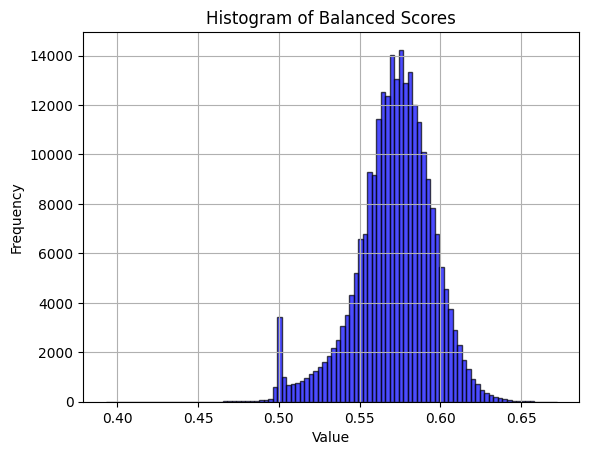

In [31]:
# Plot histogram scores
plt.hist(all_scores[:, -1].numpy(), bins=100, alpha=0.7,
         color='blue', edgecolor='black')
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Balanced Scores")
plt.grid(True)

# Show plot
plt.show()

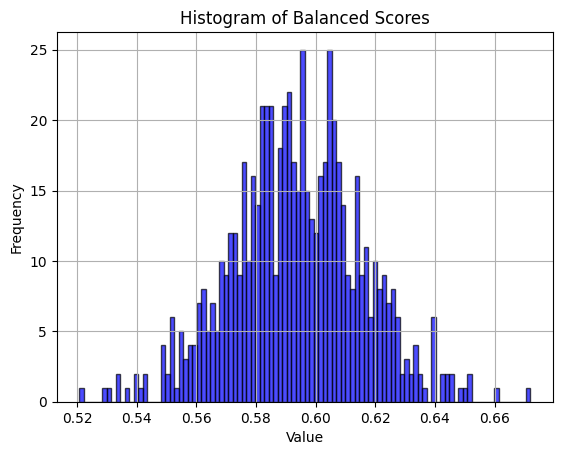

In [33]:
# Plot histogram scores
idx = (all_scores >= 0.52).all(dim=1)
filtered_scores = all_scores[idx]
plt.hist(filtered_scores[:, -1].numpy(), bins=100, alpha=0.7,
         color='blue', edgecolor='black')
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Balanced Scores")
plt.grid(True)

# Show plot
plt.show()

In [34]:
lower_bound = 0.52

idx = (all_scores >= lower_bound).all(dim=1)

all_labels = all_labels[idx]
all_params = all_params[idx]
all_scores = all_scores[idx]

## Black-box attack

In [35]:
# Black-box attack
X, y = all_scores, all_labels

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

# Define and train the MLP model
mlp_bb = MLPClassifier(hidden_layer_sizes=(256, 128, 64, 32,),
                       activation="relu",
                       solver="adam",
                       max_iter=1000)
mlp_bb.fit(X_train, y_train)

# Save model
attack_model_dir = os.path.join(cwd, 'attack_models', model_name)
os.makedirs(attack_model_dir, exist_ok=True)

# joblib.dump(mlp_bb, os.path.join(attack_model_dir,
#                                  'mlp_attacker_multilabel_bb.pkl'))

['/home/jose/VSCodeProjects/LORIS/attacks/attack_models/nn2/mlp_attacker_multilabel_bb.pkl']

In [36]:
attack_model_dir = os.path.join(cwd, 'attack_models', model_name)
mlp_bb = joblib.load(os.path.join(attack_model_dir,
                                  'mlp_attacker_multilabel_bb.pkl'))

In [37]:
# Predict probabilities and binary labels
y_pred = mlp_bb.predict(X_test)

# Evaluate using F1-score
print("F1-score:", f1_score(y_test, y_pred, average="micro"))
print()

# Compute the confusion matrix for each label separately
conf_matrices = multilabel_confusion_matrix(y_test, y_pred)

# Display confusion matrices per class
for i, cm in enumerate(conf_matrices):
    cm_sum = cm.astype(np.float64).sum(axis=1, keepdims=True)  # Sum per row
    cm_normalized = cm / (cm_sum + 1e-9)  # Avoid division by zero
    print(f"Confusion Matrix for Class {i} - {datasets[i]}:\n{cm_normalized}\n")
print()

# Generate a detailed classification report
print(classification_report(y_test, y_pred, zero_division=0))

F1-score: 0.6096256684491979

Confusion Matrix for Class 0 - Chowell_train:
[[1. 0.]
 [1. 0.]]

Confusion Matrix for Class 1 - Chowell_test:
[[0.76470588 0.23529412]
 [0.01234568 0.98765432]]

Confusion Matrix for Class 2 - MSK1:
[[1.         0.        ]
 [0.97368421 0.02631579]]

Confusion Matrix for Class 3 - MSK2:
[[1. 0.]
 [1. 0.]]

Confusion Matrix for Class 4 - Shim_NSCLC:
[[0.96491228 0.03508772]
 [0.90666667 0.09333333]]

Confusion Matrix for Class 5 - Kato_panCancer:
[[1. 0.]
 [1. 0.]]

Confusion Matrix for Class 6 - Vanguri_NSCLC:
[[0.70512821 0.29487179]
 [0.74074074 0.25925926]]

Confusion Matrix for Class 7 - Ravi_NSCLC:
[[0. 1.]
 [0. 1.]]

Confusion Matrix for Class 8 - Pradat_panCancer:
[[0.61111111 0.38888889]
 [0.32291667 0.67708333]]


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        42
           1       0.87      0.99      0.92        81
           2       1.00      0.03      0.05        38
           3       

## White-box attack

In [38]:
# White-box attack
X, y = all_params, all_labels

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

# Define and train the MLP model
mlp_wb = MLPClassifier(hidden_layer_sizes=(256, 128, 64, 32),
                       activation="relu",
                       solver="adam",
                       max_iter=1000)
mlp_wb.fit(X_train, y_train)

# Save model
attack_model_dir = os.path.join(cwd, 'attack_models', model_name)
os.makedirs(attack_model_dir, exist_ok=True)

# joblib.dump(mlp_wb, os.path.join(attack_model_dir,
#                                  'mlp_attacker_multilabel_wb.pkl'))

['/home/jose/VSCodeProjects/LORIS/attacks/attack_models/nn2/mlp_attacker_multilabel_wb.pkl']

In [39]:
attack_model_dir = os.path.join(cwd, 'attack_models', model_name)
mlp_wb = joblib.load(os.path.join(attack_model_dir,
                                  'mlp_attacker_multilabel_wb.pkl'))

In [40]:
# Predict probabilities and binary labels
y_pred = mlp_wb.predict(X_test)

# Evaluate using F1-score
print("F1-score:", f1_score(y_test, y_pred, average="micro"))
print()

# Compute the confusion matrix for each label separately
conf_matrices = multilabel_confusion_matrix(y_test, y_pred)

# Display confusion matrices per class
for i, cm in enumerate(conf_matrices):
    cm_sum = cm.astype(np.float64).sum(axis=1, keepdims=True)  # Sum per row
    cm_normalized = cm / (cm_sum + 1e-9)  # Avoid division by zero
    print(f"Confusion Matrix for Class {i} - {datasets[i]}:\n{cm_normalized}\n")
print()

# Generate a detailed classification report
print(classification_report(y_test, y_pred, zero_division=0))

F1-score: 0.5765258215962441

Confusion Matrix for Class 0 - Chowell_train:
[[0.86666667 0.13333333]
 [0.9047619  0.0952381 ]]

Confusion Matrix for Class 1 - Chowell_test:
[[0.31372549 0.68627451]
 [0.33333333 0.66666667]]

Confusion Matrix for Class 2 - MSK1:
[[0.89361702 0.10638298]
 [0.89473684 0.10526316]]

Confusion Matrix for Class 3 - MSK2:
[[0.89473684 0.10526316]
 [0.97297297 0.02702703]]

Confusion Matrix for Class 4 - Shim_NSCLC:
[[0.66666667 0.33333333]
 [0.64       0.36      ]]

Confusion Matrix for Class 5 - Kato_panCancer:
[[0.81818182 0.18181818]
 [0.77272727 0.22727273]]

Confusion Matrix for Class 6 - Vanguri_NSCLC:
[[0.58974359 0.41025641]
 [0.51851852 0.48148148]]

Confusion Matrix for Class 7 - Ravi_NSCLC:
[[0.         1.        ]
 [0.03389831 0.96610169]]

Confusion Matrix for Class 8 - Pradat_panCancer:
[[0.30555556 0.69444444]
 [0.30208333 0.69791667]]


              precision    recall  f1-score   support

           0       0.25      0.10      0.14        42

# Explore accuracies by dataset

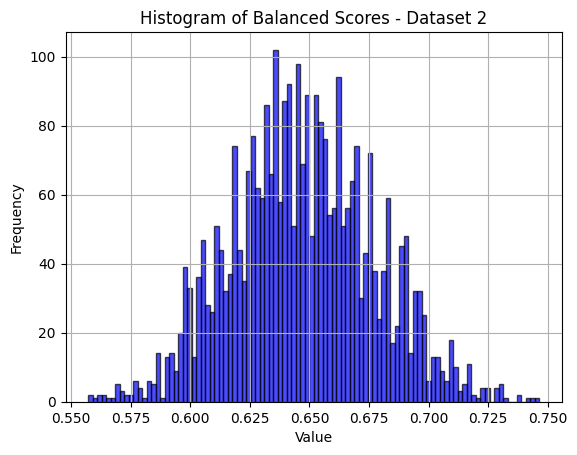

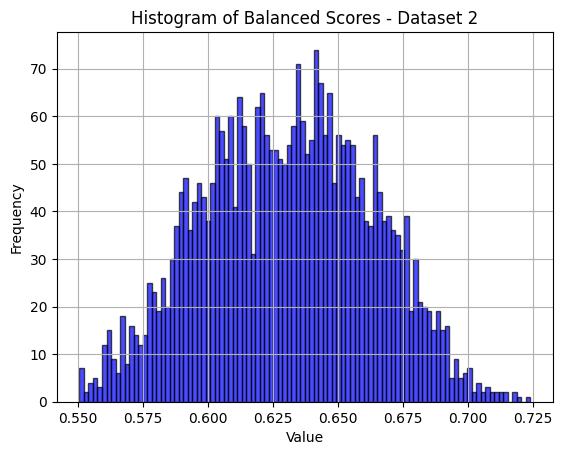

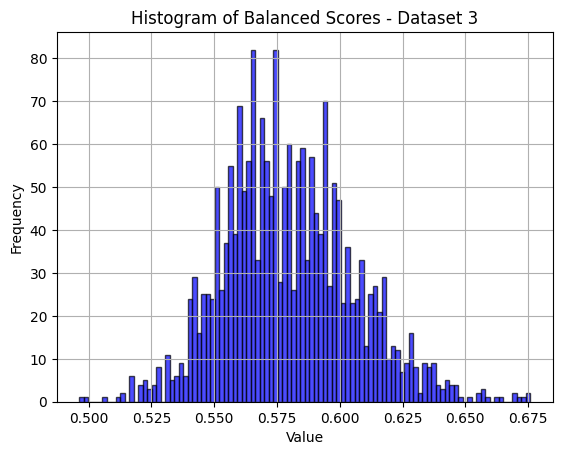

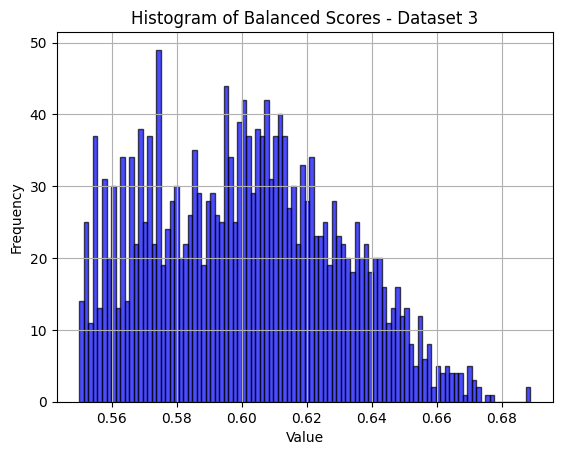

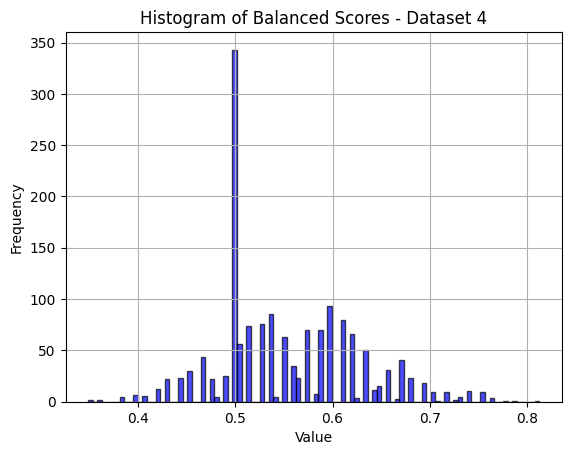

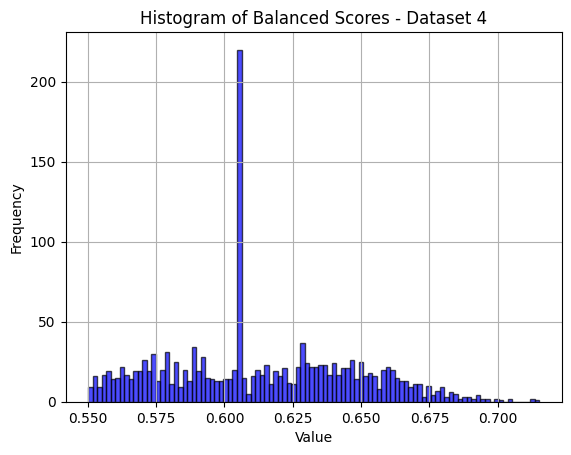

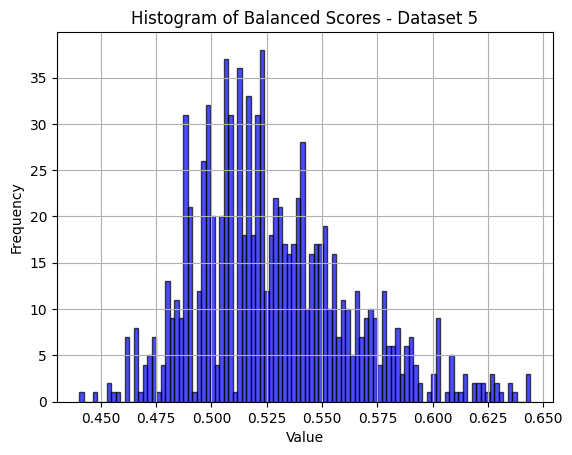

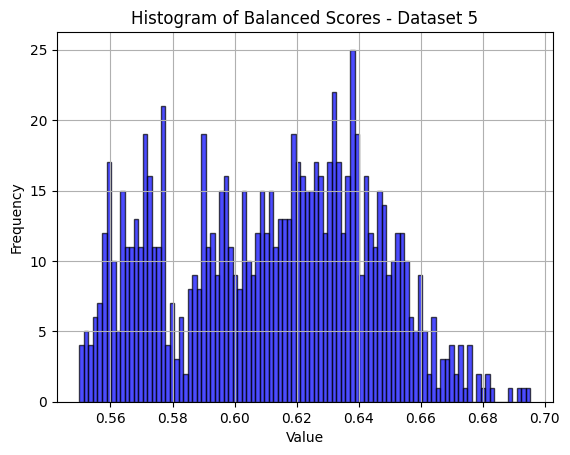

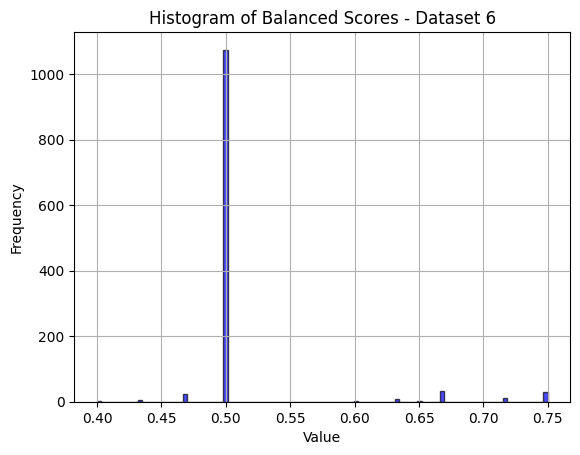

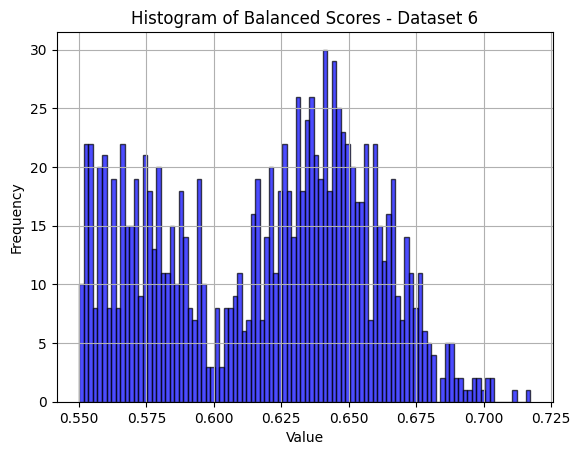

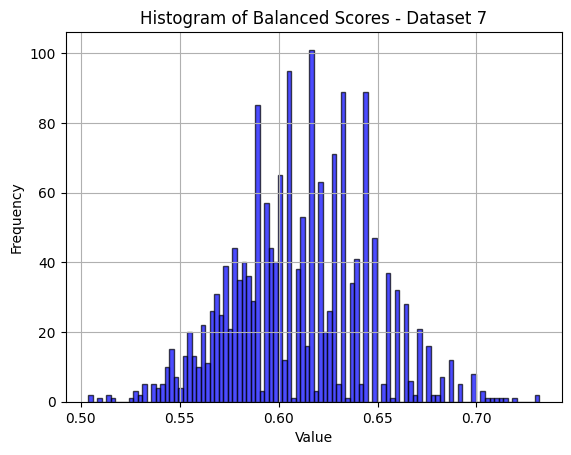

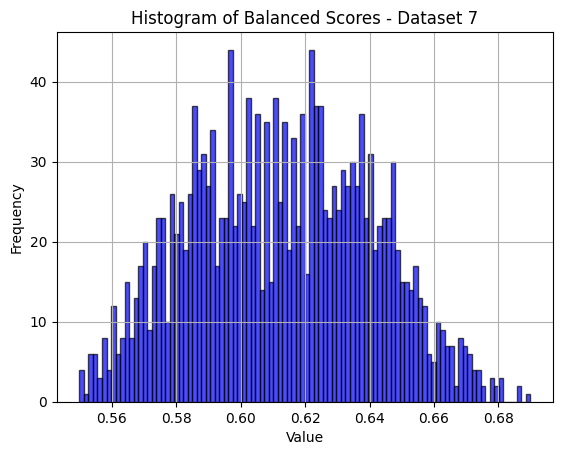

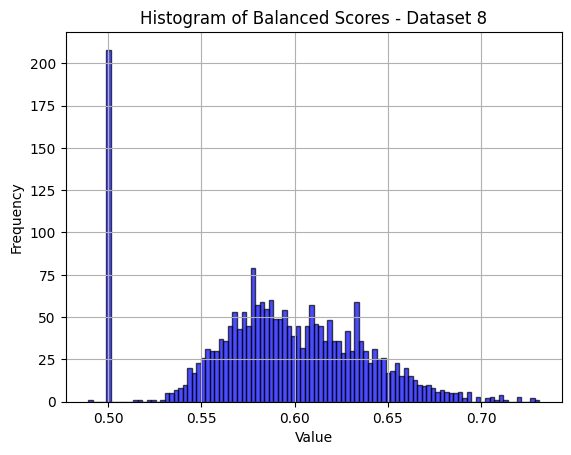

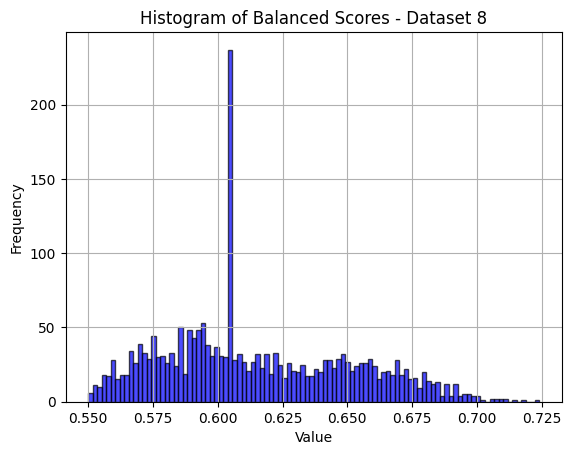

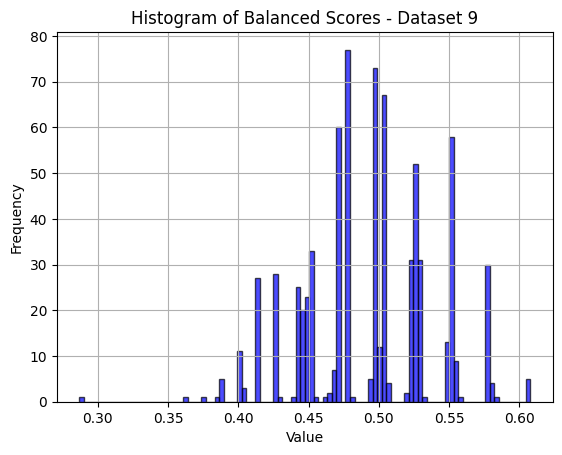

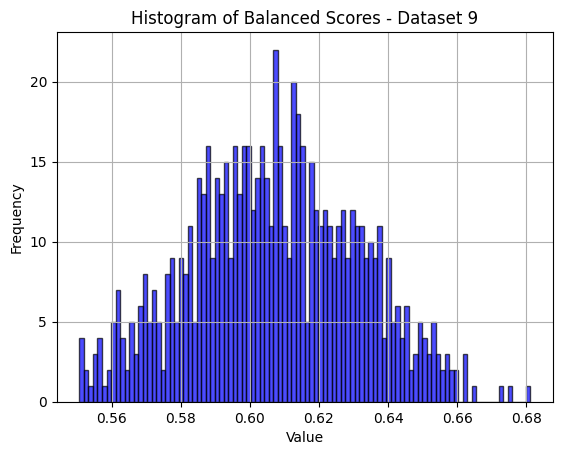

In [ ]:
for i in range(1, len(datasets)):
    ids_1 = all_labels[:, i].bool()
    ids = all_labels[:, i].bool()
    only_two = all_labels.sum(dim=1) == 2
    overall_score_cond = all_scores[:, -1] >= 0.55
    
    ids = ids_1 * ids * only_two * overall_score_cond
    
    
    scores_dataset = all_scores[ids, i]

    # Plot histogram scores
    plt.hist(scores_dataset.numpy(), bins=100, alpha=0.7,
             color='blue', edgecolor='black')
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.title(f"Histogram of Balanced Scores - Dataset {i + 1}")
    plt.grid(True)

    # Show plot
    plt.show()
    
    
    scores_dataset = all_scores[ids, -1]

    # Plot histogram scores
    plt.hist(scores_dataset.numpy(), bins=100, alpha=0.7,
             color='blue', edgecolor='black')
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.title(f"Histogram of Balanced Scores - Dataset {i + 1}")
    plt.grid(True)

    # Show plot
    plt.show()

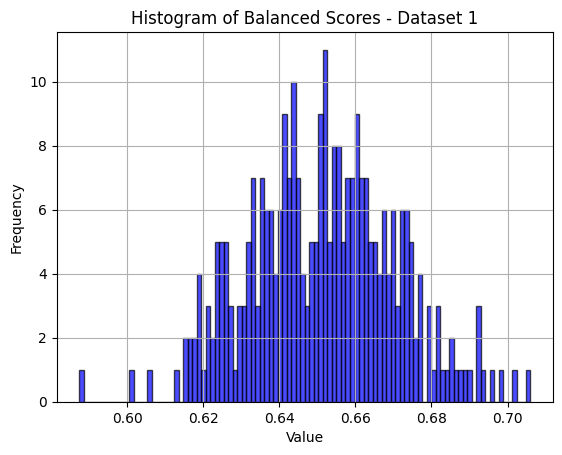

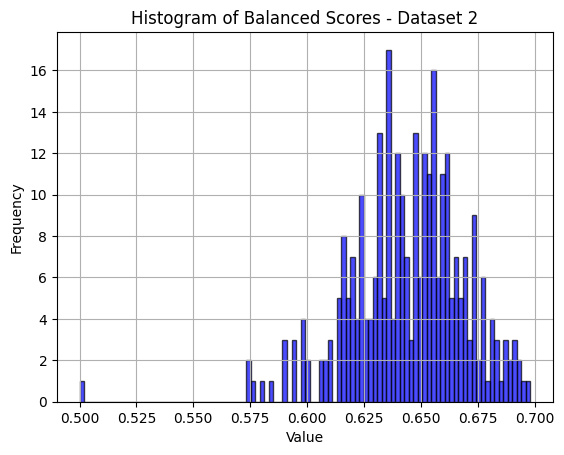

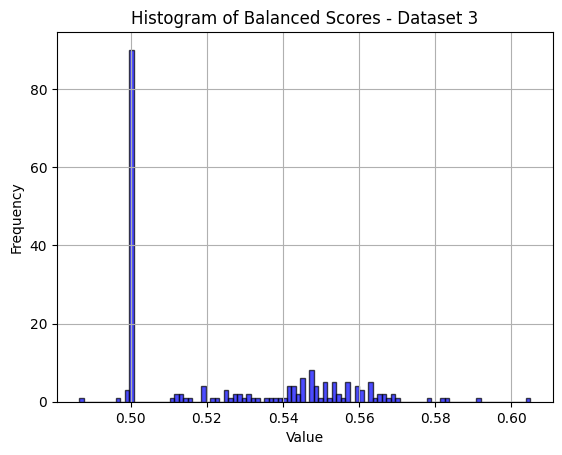

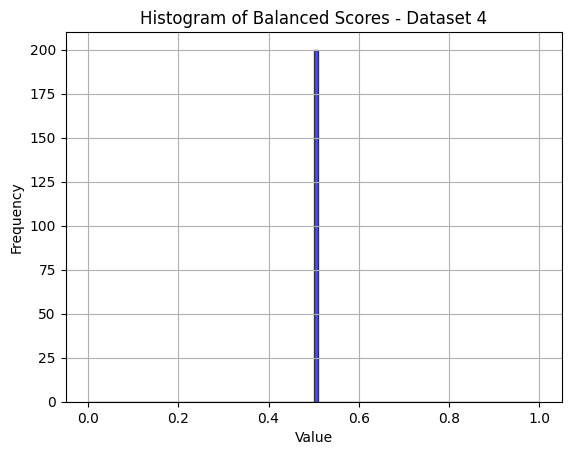

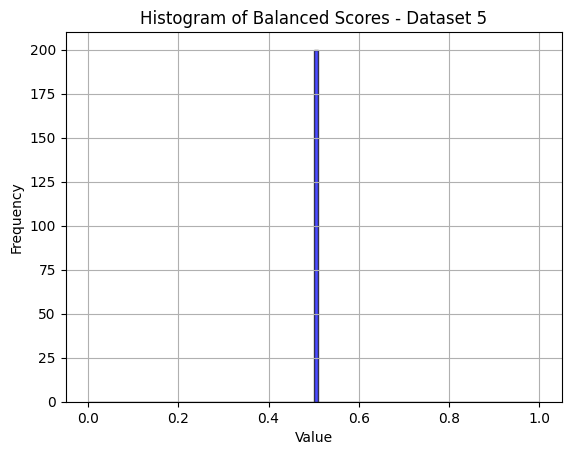

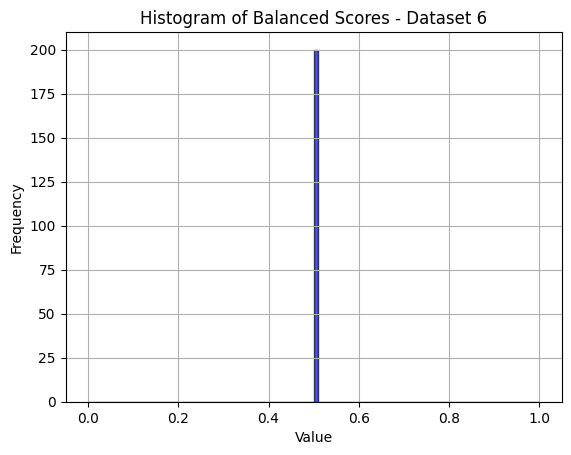

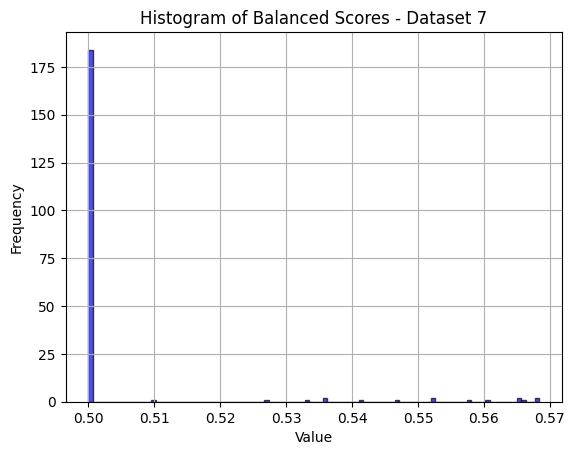

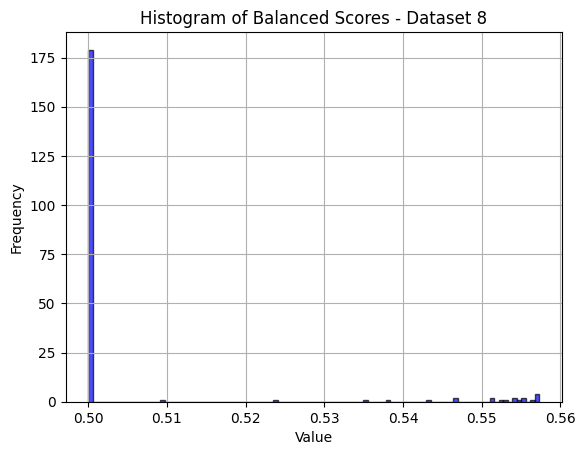

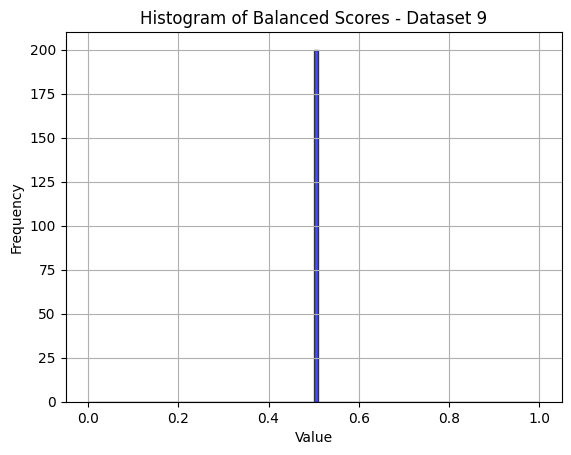

In [ ]:
for i in range(len(datasets)):
    ids = all_labels[:, i].bool()
    scores_dataset = all_scores[ids]

    # Plot histogram scores
    plt.hist(scores_dataset.numpy(), bins=100, alpha=0.7,
             color='blue', edgecolor='black')
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.title(f"Histogram of Balanced Scores - Dataset {i + 1}")
    plt.grid(True)

    # Show plot
    plt.show()

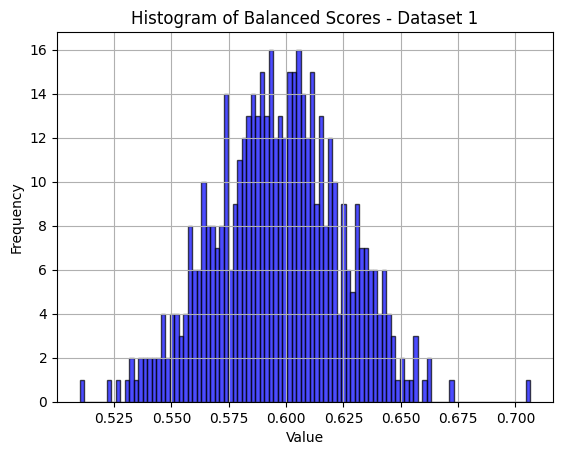

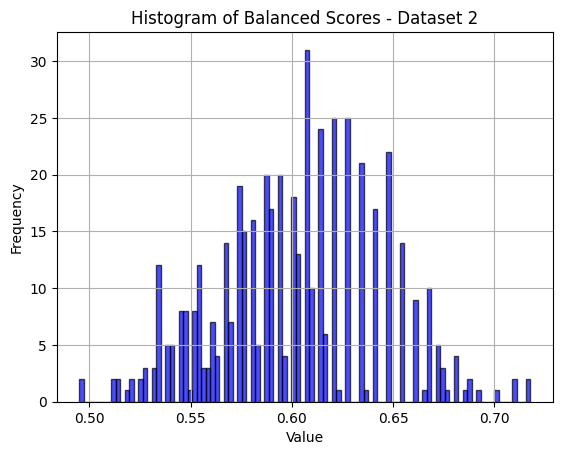

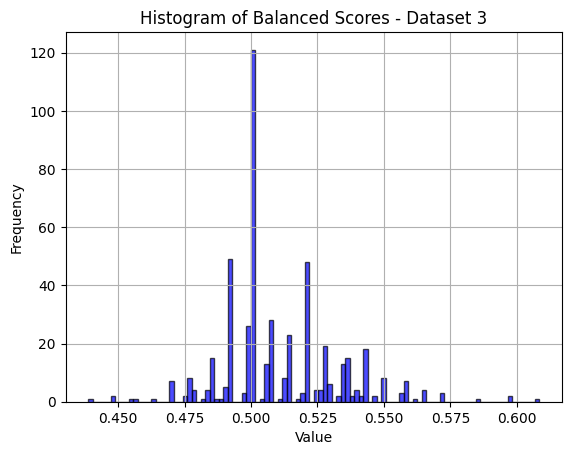

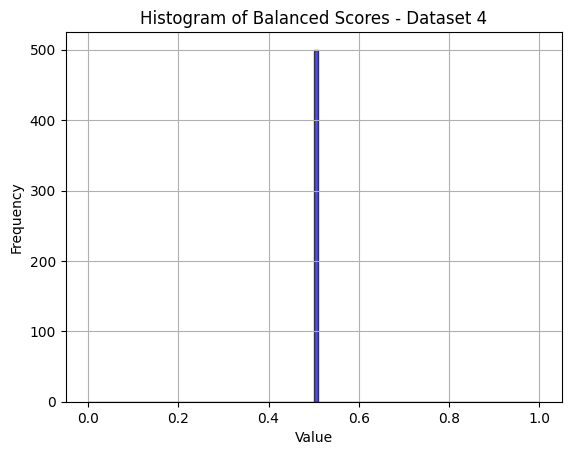

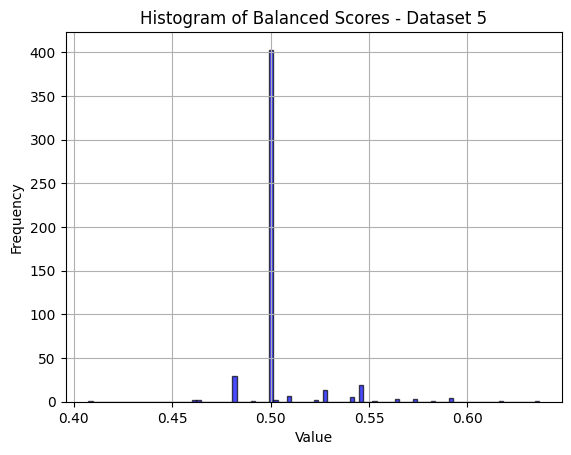

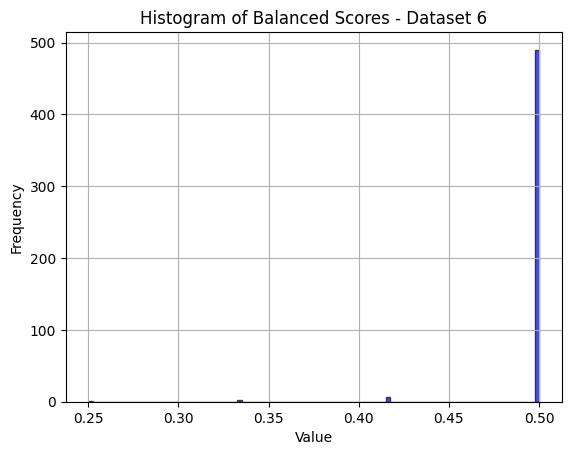

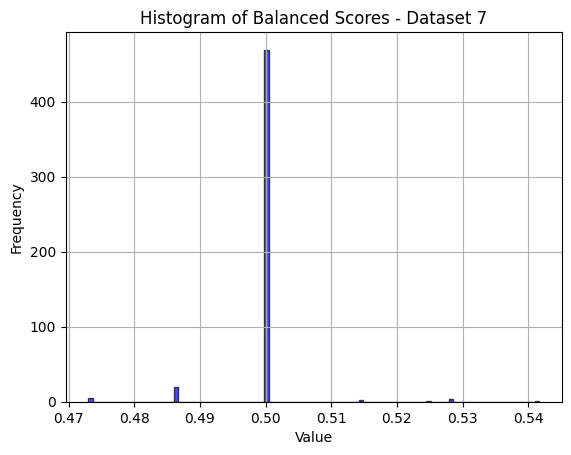

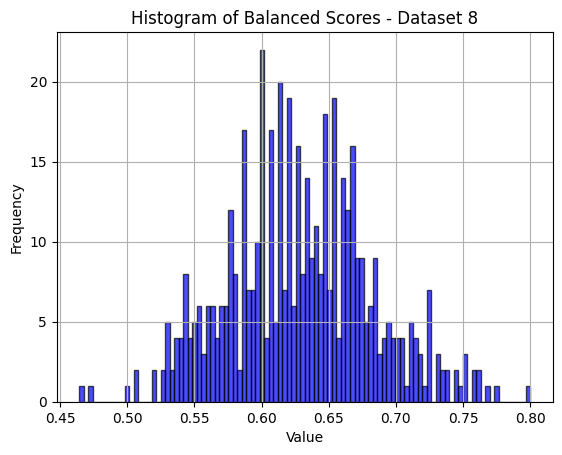

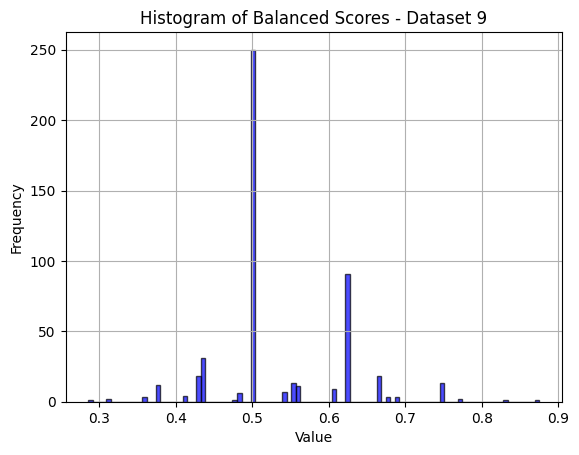

In [ ]:
for i in range(len(datasets)):
    ids = all_labels[:, i].bool()
    only_one = all_labels.sum(dim=1) == 1
    ids = ids * only_one
    scores_dataset = all_scores[ids]

    # Plot histogram scores
    plt.hist(scores_dataset.numpy(), bins=100, alpha=0.7,
             color='blue', edgecolor='black')
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.title(f"Histogram of Balanced Scores - Dataset {i + 1}")
    plt.grid(True)

    # Show plot
    plt.show()

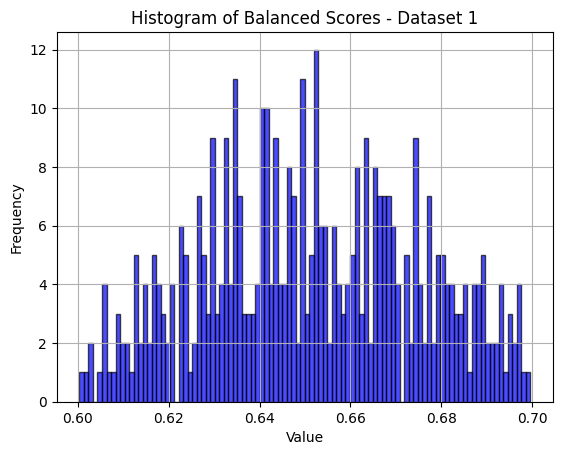

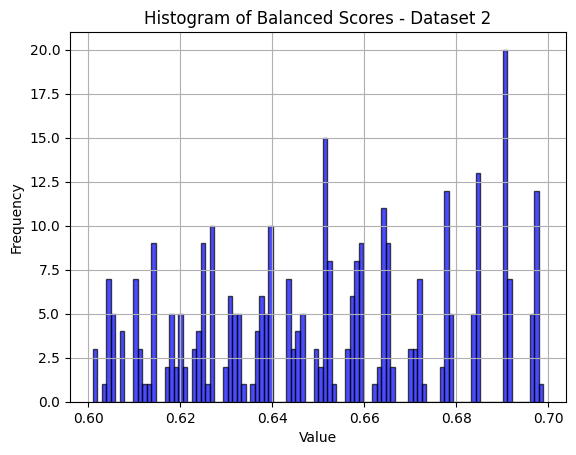

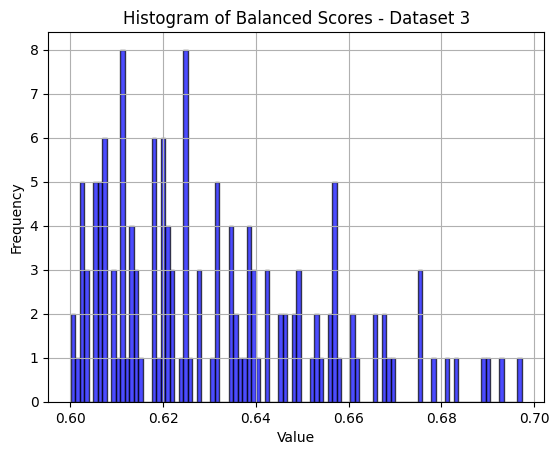

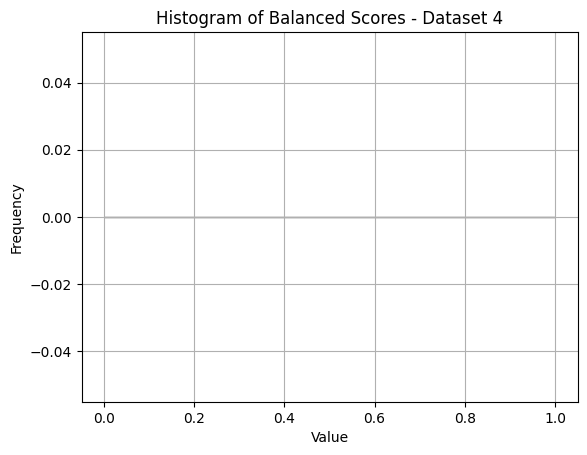

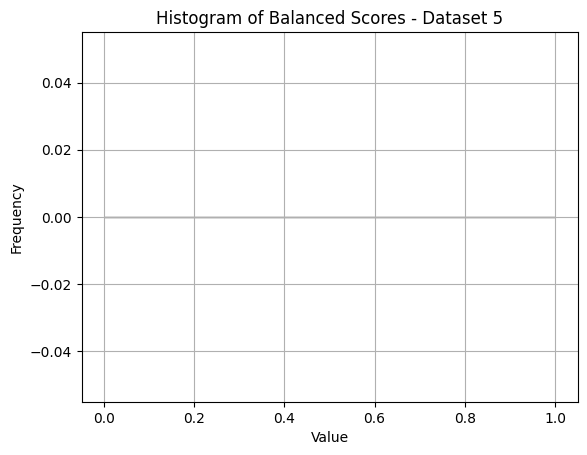

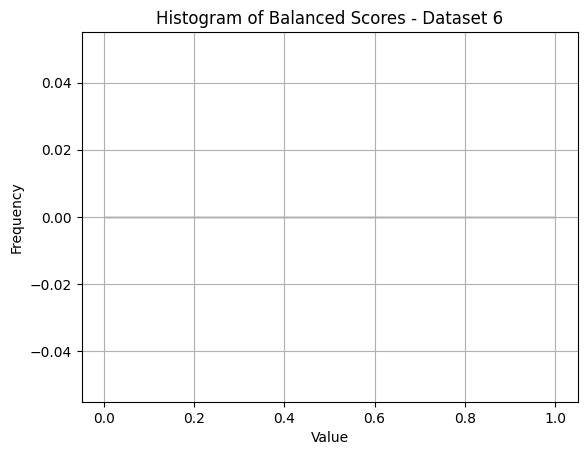

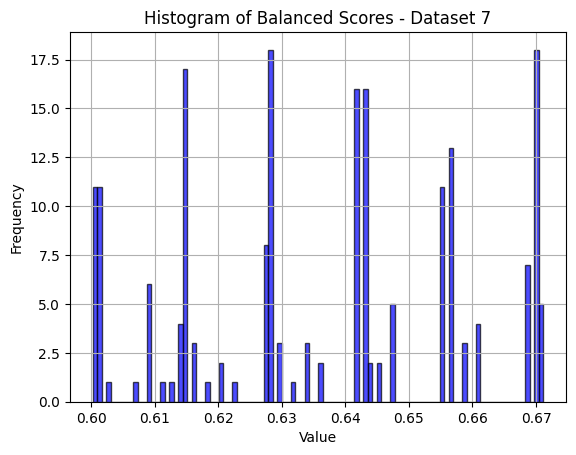

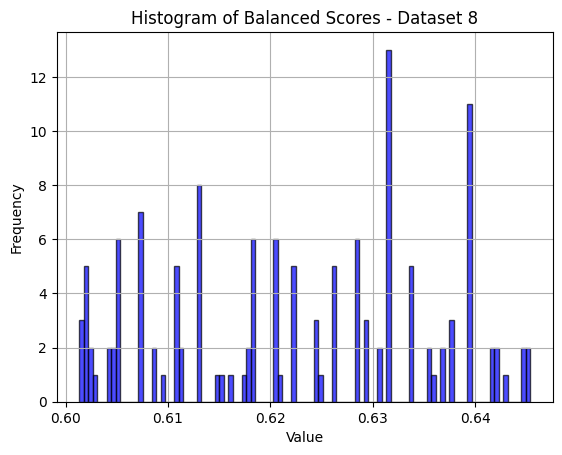

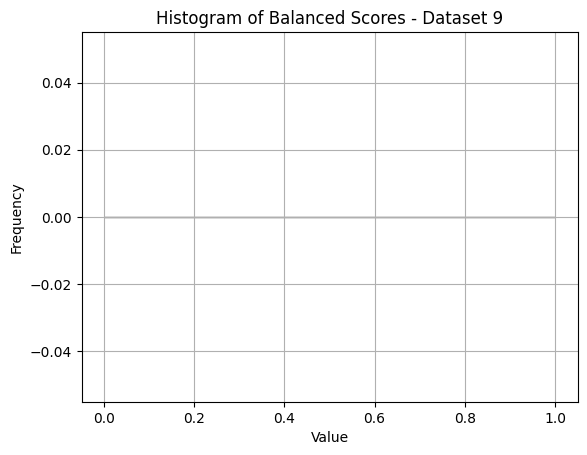

In [ ]:
score_interval = [0.6, 0.7]
score_cond = (all_scores >= score_interval[0]) * \
             (all_scores <= score_interval[1])

all_labels = all_labels[score_cond]
all_params = all_params[score_cond]
all_scores = all_scores[score_cond]

for i in range(len(datasets)):
    ids = all_labels[:, i].bool()
    only_one = all_labels.sum(dim=1) == 1
    ids = ids * only_one
    scores_dataset = all_scores[ids]

    # Plot histogram scores
    plt.hist(scores_dataset.numpy(), bins=100, alpha=0.7,
             color='blue', edgecolor='black')
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.title(f"Histogram of Balanced Scores - Dataset {i + 1}")
    plt.grid(True)

    # Show plot
    plt.show()